In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

Download GOES ABI-L1b-RadC band 14 imagery for for Feb 1-15 2020, and create timeseries files for the two Grand Mesa SnowEx 2020 field locations, using the goes-ortho library and command line utilities.

**Download imagery:**

Longwave window (11.2 micron):
* GOES-16 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
  
Shortwave window (3.9 micron):
* GOES-16 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
  
Visible (red, 0.64 micron):
* GOES-16 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`
* GOES-17 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`

**Create timeseries files:**
* Grand Mesa West:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0339 -108.2140 3033`
      * *GrandMesaWest_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * ...
      * ...
  * Create GOES-17 timeseries:
    * Langwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/02 -l 39.0339 -108.2140 3033`
      * ...
    * Shortwave Window:
      * ...
      * ...
* Snow Pit 2S10:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl*
  * Create GOES-17 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-17_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl*

In [2]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

Read in the data file:

In [3]:
# Set column headers:
headers_gm1 = ['table', 'year', 'doy', 'time',
               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
               'batt','b',]

# Open ground data from GM1 site:
gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
                 header = None, names = headers_gm1)

Perform some formatting and cleanup:

In [4]:
# Pad zeros to time strings
gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]

for i in range(gm1.shape[0]):
    if gm1.time_str[i] == '2400':
        gm1.time_str[i] = '0000'
        gm1.doy[i] = gm1.doy[i] + 1
        
# Convert year and day of year to pandas datetime index:
gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i])) for i in range(gm1.shape[0])]

# Get table 102 entires, battery info
gm1_102 = gm1[gm1.table == 102]

# Remove entries that are part of "Table 102"
gm1 = gm1[gm1.table != 102]

# Remove dates before observation periods (Feb 5th for GM1)
gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Inspect the data series:

In [5]:
gm1.tail()

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt,b,time_str,date
2020-02-12 15:10:00,101,2020,43,1510,-9.3700,-9.0437,-9.7752,0.184,-5.9076,-5.8069,...,-7.3058,0.009,-6.1055,-6.1015,-6.1066,0.002,NaN,NaN,1510,2020-02-12
2020-02-12 15:15:00,101,2020,43,1515,-8.9315,-8.4953,-9.5780,0.336,-6.0095,-5.9826,...,-7.2757,0.013,-6.0973,-6.0916,-6.1065,0.005,NaN,NaN,1515,2020-02-12
2020-02-12 15:20:00,101,2020,43,1520,-10.1200,-9.7869,-10.4040,0.215,-6.4162,-6.0925,...,-7.2557,0.009,-6.1010,-6.0916,-6.1064,0.004,NaN,NaN,1520,2020-02-12
2020-02-12 15:25:00,101,2020,43,1525,-9.5534,-9.2206,-9.9084,0.236,-6.7033,-6.6493,...,-7.2357,0.013,-6.0921,-6.0867,-6.1015,0.005,NaN,NaN,1525,2020-02-12
2020-02-12 15:30:00,101,2020,43,1530,-9.6601,-8.9519,-10.7450,0.551,-6.6635,-6.5886,...,-7.1959,0.005,-6.0883,-6.0868,-6.0918,0.002,NaN,NaN,1530,2020-02-12


Plot:

Text(0.5, 1.0, 'Snow Temperature Profile at Snow Pit 2S10')

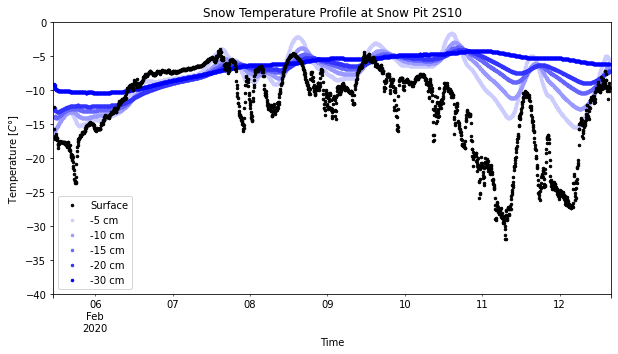

In [6]:
f, ax1 = plt.subplots(1,1,figsize=(10,5))

startdate = pd.datetime(2020,2,5,11,0)
enddate = pd.datetime(2020,2,12,16,0)

gm1.rad_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c='k', label='Surface', zorder=99)
gm1.temp1_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c=[0.8,0.8,1], label='-5 cm')
gm1.temp2_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c=[0.6,0.6,1], label='-10 cm')
gm1.temp3_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c=[0.4,0.4,1], label='-15 cm')
gm1.temp4_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c=[0.2,0.2,1], label='-20 cm')
gm1.temp5_avg.plot(ax=ax1, linestyle='none', marker='.', markersize=5, c=[0,0,1], label='-30 cm')
ax1.set_ylim((-40,0))
ax1.set_xlim((startdate,enddate))
ax1.legend()
ax1.set_ylabel('Temperature [$C\degree$]')
ax1.set_xlabel('Time')
ax1.set_title('Snow Temperature Profile at Snow Pit 2S10')

---

Read in GOES ABI, Band 14 (Longwave Window) brightness temperature timeseries:

In [7]:
# Read files
g16_b14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_timeseries_Feb2020.pkl')
g17_b14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_b14.index  = pd.to_datetime(g16_b14.time) - pd.Timedelta(hours=7)
g17_b14.index  = pd.to_datetime(g17_b14.time) - pd.Timedelta(hours=7)

Read in GOES ABI, Band 7 (Shortwave Window) brightness temperature timeseries:

In [8]:
# Read files
g16_b7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl')
g17_b7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_b7.index  = pd.to_datetime(g16_b7.time) - pd.Timedelta(hours=7)
g17_b7.index  = pd.to_datetime(g17_b7.time) - pd.Timedelta(hours=7)

---
### Plot all together:

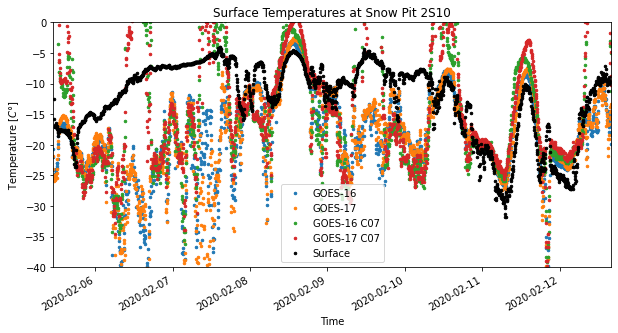

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

startdate = pd.datetime(2020,2,5,11,0)
enddate = pd.datetime(2020,2,12,16,0)

g16_b14.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:blue', label='GOES-16', zorder=0)
g17_b14.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:orange', label='GOES-17', zorder=0)

g16_b7.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:green', label='GOES-16 C07', zorder=0)
g17_b7.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:red', label='GOES-17 C07', zorder=0)

gm1.rad_avg.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='k', label='Surface', zorder=99)

ax.set_ylim((-40,0))
ax.set_xlim((startdate,enddate))

ax.legend()
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_xlabel('Time')
ax.set_title('Surface Temperatures at Snow Pit 2S10');

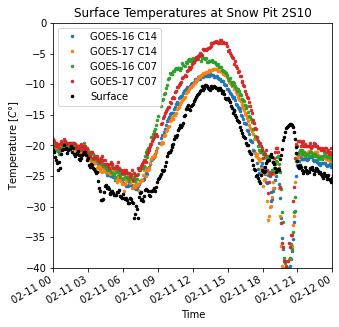

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

g16_b14.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:blue', label='GOES-16 C14', zorder=0)
g17_b14.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:orange', label='GOES-17 C14', zorder=0)

g16_b7.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:green', label='GOES-16 C07', zorder=0)
g17_b7.tb.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='tab:red', label='GOES-17 C07', zorder=0)


gm1.rad_avg.plot(ax=ax, linestyle='none', marker='.', markersize=5, c='k', label='Surface', zorder=99)


ax.set_ylim((-40,0))
ax.set_xlim((startdate,enddate))

ax.legend()
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_xlabel('Time')
ax.set_title('Surface Temperatures at Snow Pit 2S10');